## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [58]:
td = pd.read_csv('data/ab_data_tourist.csv',sep=',')
td.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [59]:
td.info()
td['date'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 294478 entries, 0 to 294477
Series name: date
Non-Null Count   Dtype 
--------------   ----- 
294478 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


**Object**

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [60]:
td['date'] = pd.to_datetime(td['date'], format='%Y-%m-%d')
td_grp_date = td.groupby('group')['date'].agg(['max', 'min'])
display(td_grp_date)

,max,min
group,,
A,2021-01-24,2021-01-02
B,2021-01-24,2021-01-02


**02-24.01.2021**

## **Задание 7.3.**

1. Чему равно количество посещений сайта в группах А и B?

1. Чему равно суммарное количество покупок в группах А и B?

1. Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [61]:
td_grp_enter = td.groupby('group')['user_id'].agg(['count'])
display('Количество посещений',td_grp_enter)

td_grp_prch = td.groupby('group')['purchase'].agg(['sum'])
display('Cуммарное количество покупок',td_grp_prch)

td_grp_price = td.groupby('group')['price'].agg(['sum'])
display('Cумма всех покупок (в млн. руб.)',td_grp_price / 1000000)

'Количество посещений'

,count
group,
A,147202
B,147276


'Cуммарное количество покупок'

,sum
group,
A,17723
B,17514


'Cумма всех покупок (в млн. руб.)'

,sum
group,
A,1436.26
B,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [62]:
td_grp_A = set(td['user_id'][td['group']=='A'])
td_grp_B = set(td['user_id'][td['group']=='B'])

td_id_intersect = set(td_grp_A.intersection(td_grp_B))
print(len(td_id_intersect))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [63]:
display(td.info())
td_upd = td[td['user_id'].apply(lambda x: x not in td_id_intersect)]
display(td_upd.info())
td = td_upd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


None

Где td_id_intersect - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

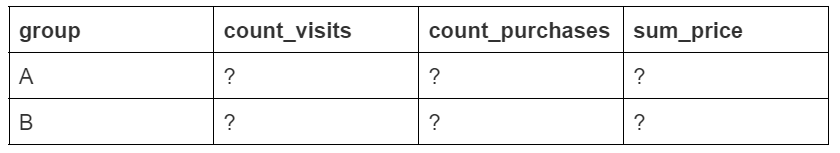

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

Чему на этот раз равно количество посещений сайта в группах А и B?


In [64]:
td_showie = pd.DataFrame()

td_showie['count_visits'],\
    td_showie['count_purchases'],\
    td_showie['sum_price'] =\
    td.groupby(by='group')['price'].count(),\
    td.groupby(by='group')['purchase'].sum(),\
    td.groupby(by='group')['price'].sum()

display(td_showie.head())

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы, можно ли говорить о сбалансированности выборок?

In [65]:
td_bfr_visits = td_grp_enter['count']['A']\
    / td_grp_enter['count']['B']
td_now_visits = td_showie['count_visits']['A']\
    / td_showie['count_visits']['B']
td_dif_visits = td_bfr_visits / td_now_visits

print('Посещения сайта А к сайту Б \"до\":', td_bfr_visits)
print('Посещения сайта А к сайту Б \"после\":', td_now_visits)
print('Их соотношение', td_dif_visits)

Посещения сайта А к сайту Б "до": 0.9994975420299302
Посещения сайта А к сайту Б "после": 0.9994909926331501
Их соотношение 1.000006552732169


**Вывод:** *Т.к. разница обнаруживается только с шестого знака после запятой, полагаю, что удаление посетителей обеих страниц не сказалось значительно на нашей выборке.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [66]:
td_showie['conversion'], td_showie['mean_check'] =\
    td_showie['count_purchases']/td_showie['count_visits']*100,\
    td_showie['sum_price']/td_showie['count_purchases']

display(td_showie)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Вывод:** *Вариант А эффективнее по количеству продаж и, следовательно, конверсии. Но, при меньших продажах, вариант Б продаёт более дорогие туры чаще, потому средний чек и суммарная выручка больше у него, не у А.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [67]:
table = td.pivot_table(
    values='purchase',
    index='price',
    columns='group',
    aggfunc='count'
)

display(table)

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

**Ответ:** 5271 и 1730 туров в группах А и В соответственно.

<AxesSubplot:xlabel='group', ylabel='price'>

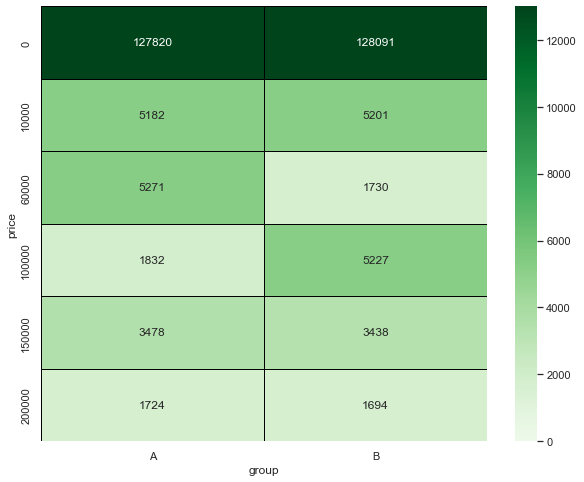

In [68]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.heatmap(table, annot = True, vmin=0, vmax=13000,\
    center=6000, cmap='Greens', fmt='1g', linecolor='Black',\
    linewidth=1)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

In [69]:
display(round(table['B']/table['A'], 2))
print('Сумма продаж туров за 60 и 100 т.р. в группах:')
print('А: {}; B: {}'.format(table['A'][100000]+\
    table['A'][60000], table['B'][100000]+table['B'][60000]))
print('При примерно одинаковом числе покупателей')
print('разница прибылей составила:',
    (table['B'][100000]*100000+table['B'][60000]*60000)\
    -(table['A'][100000]*100000+table['A'][60000]*60000),\
    'руб.')

price
0         1.00
10000     1.00
60000     0.33
100000    2.85
150000    0.99
200000    0.98
dtype: float64

Сумма продаж туров за 60 и 100 т.р. в группах:
А: 7103; B: 6957
При примерно одинаковом числе покупателей
разница прибылей составила: 127040000 руб.


**Выводы:**
Как видно по графику и таблице, заметной разницы (в ~3 раза) достигают только две ценовые категории: 60 и 100 т.р. Это говорит о том, что:

* Разница между 60 и 100 т.р. может казаться потребителю не такой ощутимой, как между другими категориями;
* Потому часть покупателей тура за 60 т.р. на сайте А имеют возможность купить более дорогой тур;
* И видеовставка на сайте туроператора подтолкнула их к этому.

Т.е., благодаря размещению видео, получилось убедить часть аудитории сайта купить более дорогой продукт.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок.

In [70]:
td_dg = pd.DataFrame(\
    td.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
}))

display(td_dg.head())

,date,group,count_visits,count_purchases,sum_price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)

In [71]:
td_dg['conversion'] = td_dg['count_purchases']/td_dg['count_visits'] * 100
td_dg['mean_check'] = td_dg['sum_price']/td_dg['count_purchases']

display(td_dg.head())


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


1. Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

2. Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [72]:
display(td_dg[td_dg['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion','mean_check']])

,group,conversion,mean_check
2,A,11.340206,82887.700535
3,B,11.391449,87480.106101


**Ответы:** (1) 11.34 и 11.39; (2) 82888 и 87480.

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:

1. кумулятивное количество посещений страницы
2. кумулятивное количество покупок
3. кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [73]:
# 1
td_dg['cum_visits'] = td_dg.groupby(['group'])['count_visits'].cumsum()
# 2
td_dg['cum_purchases'] = td_dg.groupby(['group'])['count_purchases'].cumsum()
# 3
td_dg['cum_sum_price'] = td_dg.groupby(['group'])['sum_price'].cumsum().round(2)

td_dg['cum_conversion'] = td_dg['cum_purchases']/td_dg['cum_visits']*100

td_dg['cum_mean_check'] = td_dg['cum_sum_price']/td_dg['cum_purchases'].round(0)


display(td_dg.loc[(td_dg['group']=='B')&(td_dg['date'] == pd.to_datetime('2021-01-20'))]['cum_conversion'])

display(td_dg.loc[(td_dg['group']=='A')&(td_dg['date'] == pd.to_datetime('2021-01-12'))]['cum_mean_check'])

37    11.895911
Name: cum_conversion, dtype: float64

20    81491.827275
Name: cum_mean_check, dtype: float64

In [74]:
td_dg_a = td_dg[td_dg['group']=='A']
td_dg_b = td_dg[td_dg['group']=='B']

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

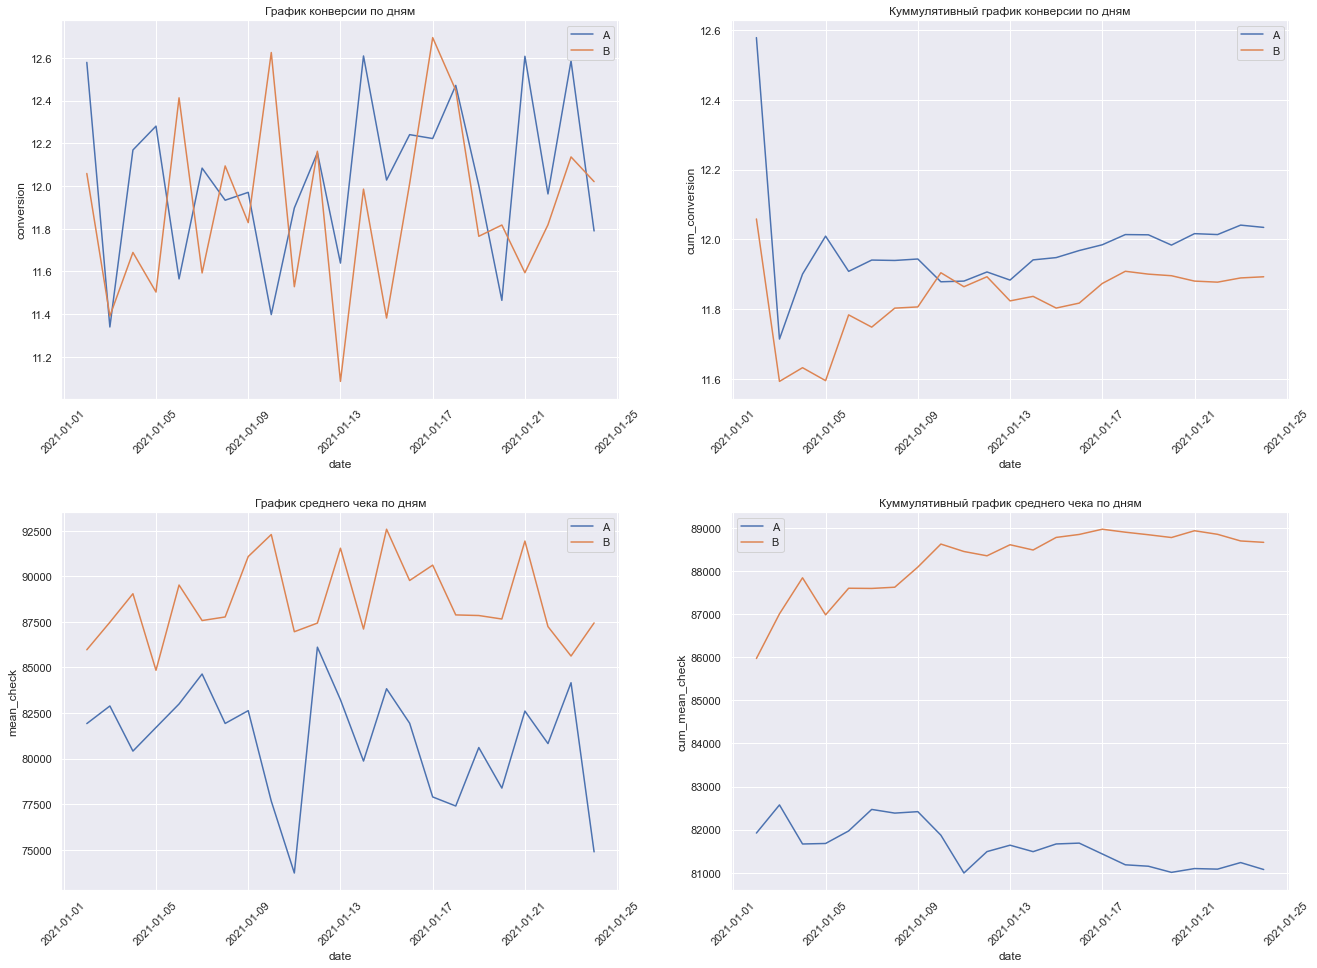

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(22, 16))
plt.subplots_adjust(hspace = 0.3)

sns.lineplot(x='date', y='conversion', data=td_dg_a, ax=ax1)
sns.lineplot(x='date', y='conversion', data=td_dg_b, ax=ax1)
ax1.set_title('График конверсии по дням')
ax1.xaxis.set_tick_params(rotation = 45)
ax1.legend(labels=["A","B"])
ax1.grid(True);

sns.lineplot(x='date', y='cum_conversion', data=td_dg_a, ax=ax2)
sns.lineplot(x='date', y='cum_conversion', data=td_dg_b, ax=ax2)
ax2.set_title('Куммулятивный график конверсии по дням')
ax2.xaxis.set_tick_params(rotation = 45)
ax2.legend(labels=["A","B"])
ax2.grid(True);

sns.lineplot(x='date', y='mean_check', data=td_dg_a, ax=ax3)
sns.lineplot(x='date', y='mean_check', data=td_dg_b, ax=ax3)
ax3.set_title('График среднего чека по дням')
ax3.xaxis.set_tick_params(rotation = 45)
ax3.legend(labels=["A","B"])
ax3.grid(True);

sns.lineplot(x='date', y='cum_mean_check', data=td_dg_a, ax=ax4)
sns.lineplot(x='date', y='cum_mean_check', data=td_dg_b, ax=ax4)
ax4.set_title('Куммулятивный график среднего чека по дням')
ax4.xaxis.set_tick_params(rotation = 45)
ax4.legend(labels=["A","B"])
ax4.grid(True);

**Выводы:**

1. Как видно по кумулятивным графикам, показатели постепенно выравнялись, значит тест можно считать завершённым.

2. Графики подтверждают раннее наблюдение, что группа А имеет большую конверсию, но меньший средний чек, чем группа В.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [76]:
from statsmodels.stats.weightstats import ztest as ztest

In [88]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05

_, p_value = ztest(
    td_dg.loc[(td_dg['group']=='A')]['conversion'],
    td_dg.loc[(td_dg['group']=='B')]['conversion'],
    alternative='larger'
)

print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:** *По результатам Z-теста, разница между конверсиями групп А и В минимальна, потому принятие альтернативной теории и сайта вида В не имеет смысла* ***если смотреть только на конверсию***.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [99]:
from scipy.stats import norm, t
import statistics

n = td_dg.loc[(td_dg['group']=='A')]['conversion'].count()
k = n - 1
x_mean = td_dg.loc[(td_dg['group']=='A')]['conversion'].mean()
x_std = statistics.stdev(td_dg.loc[(td_dg['group']=='A')]['conversion'], xbar=None)
gamma = 0.95
alpha = 1 - gamma

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = ((lower_bound), (upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (11.87563683376169, 12.211002892777858)


In [100]:
from scipy.stats import norm, t
import statistics

n = td_dg.loc[(td_dg['group']=='B')]['conversion'].count()
k = n - 1
x_mean = td_dg.loc[(td_dg['group']=='B')]['conversion'].mean()
x_std = statistics.stdev(td_dg.loc[(td_dg['group']=='B')]['conversion'], xbar=None)
gamma = 0.95
alpha = 1 - gamma

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = ((lower_bound), (upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (11.720432663763571, 12.0750168478558)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [111]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    print(diff)
    z_crit = -norm.ppf(alpha/2) # z критическое
    print(z_crit)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    print(z_crit, '*', (xp[0] * (1 - xp[0])/n[0]),'+', (xp[1] * (1 - xp[1])/n[1]), '**', 0.5)
    print()
    print(eps)
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)



print(1.959963984540054 * -5.637309983008563 + -5.782531889815588 ** 0.5)
n = [td_dg.loc[(td_dg['group']=='B')]['conversion'].count(), td_dg.loc[(td_dg['group']=='A')]['conversion'].count()]
xp = [td_dg.loc[(td_dg['group']=='B')]['conversion'].mean(), td_dg.loc[(td_dg['group']=='A')]['conversion'].mean()]
print(n, xp)

# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)



-13.453614098431428
[23, 23] [11.897724755809685, 12.043319863269774]
0.14559510746008897
1.959963984540054
1.959963984540054 * -5.637309983008563 + -5.782531889815588 ** 0.5

-13.453614098431428
Доверительный интервал для разности конверсий: (1359.92, -1330.8)


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 